In [9]:
#Install libraries as needed
!pip install gtfs_functions
!pip install gtfs_kit

In [2]:
#import packages
from gtfs_functions import Feed
import gtfs_kit as gk
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.ops import unary_union
import matplotlib.pyplot as plt

## Import Data
#### Import GTFS 

In [2]:
#Bring in GTFS data using gtfs_functions

#Change path to local GTFS zip
gtfs_path = r"C:\Users\cathk\GEOG490\gtfs.zip"
feed = Feed(gtfs_path, time_windows=[0, 6, 10, 12, 16, 19, 24])

In [3]:
#Bring in GTFS .txt files using feed
routes = feed.routes
trips = feed.trips
stops = feed.stops
stop_times = feed.stop_times
shapes = feed.shapes
calendar = feed.calendar

INFO:root:Reading "routes.txt".
INFO:root:accessing trips
INFO:root:Start date is None. You should either specify a start date or set busiest_date to True.
INFO:root:Reading "trips.txt".
INFO:root:Reading "calendar.txt".
INFO:root:Reading "calendar_dates.txt".
INFO:root:The busiest date/s of this feed or your selected date range is/are:  ['2023-01-02', '2022-09-05', '2022-12-26', '2022-11-24', '2022-11-25'] with 14429 trips.
INFO:root:In the case that more than one busiest date was found, the first one will be considered.
INFO:root:In this case is 2023-01-02.
INFO:root:Reading "stop_times.txt".
INFO:root:_trips is defined in stop_times
INFO:root:Reading "stops.txt".
INFO:root:computing patterns
INFO:root:Reading "shapes.txt".


#### Import Census Tract data

In [9]:
#Change path to local tract shapefile
tracts = gpd.read_file(r"C:\Users\cathk\Documents\490Final\Transportation-Access-\data\shapefiles\tl_2021_48_tract\tl_2021_48_tract.shp")

#Get county Census tract
county_tracts = tracts[tracts['COUNTYFP'] == '201']

#Reproject  county tracts to UTM for the city
county_tracts = county_tracts.to_crs("EPSG:32615")

ERROR:fiona._env:data/shapefiles/tl_2021_48_tract/tl_2021_48_tract.shp: No such file or directory


DriverError: data/shapefiles/tl_2021_48_tract/tl_2021_48_tract.shp: No such file or directory

In [5]:
county_tracts['TRACTCE'] = county_tracts['TRACTCE'].astype(int)

In [6]:
# Extract needed columns
county_tracts = county_tracts[['TRACTCE','ALAND','geometry']]

# Transit Factors and Indicators

### Factor: Connectivity to the Network
##### Indicators: Bus stop service coverage area, density of bus stops, route coverage, ADA accessibility

#### Indicator: Bus stop service coverage area
Bus stop service coverage area is determined by finding the sum of the service coverage areas of bus stops in a Census tract divided by the total area of the Census tract.

 - Service coverage areas are 400m radius buffers from each bus stop. Here overlapping areas are counted one time.


In [7]:
# Bring in the bus stops
stops = feed.stops

#Reproject the bus stops to UTM
stops_reproject = stops.to_crs("EPSG:32615")

#Buffer stops 
buffer_distance = 400 #meters
stops_buffered = stops_reproject.buffer(buffer_distance)

#Convert buffered stops geoseries to a geodataframe
stops_buffered_gdf = gpd.GeoDataFrame(geometry=stops_buffered)

In [9]:
# Calculate the areas
county_tracts['area'] = county_tracts.geometry.area

In [10]:
# Merge all the polygons into a single polygon
merged_polygon = unary_union(stops_buffered_gdf.geometry)

# Create a new GeoDataFrame with the merged polygon
merged_gdf = gpd.GeoDataFrame(geometry=[merged_polygon])

# If you want to reset the index of the DataFrame
merged_gdf.reset_index(drop=True, inplace=True)


In [11]:
# Create an empty list to store the results
area_covered_list = []

# Iterate over each row in gdf2
for _, row in county_tracts.iterrows():
    # Calculate the intersection between the row geometry of gdf2 and the geometries in gdf1
    intersection = merged_gdf.intersection(row.geometry)
    
    # Calculate the total area of the intersection
    total_intersection_area = intersection.area.sum()
    
    # Append the total intersection area to the list
    area_covered_list.append(total_intersection_area)

# Add the area_covered_list as a new column to gdf2
county_tracts['area_covered'] = area_covered_list



In [12]:
# Get the service coverage area by dividing the area_covered by the total area of the tract
county_tracts['service_coverage']=county_tracts['area_covered']/county_tracts['area']

#### Indicator: Density of bus stops
The density of bus stops is determined by dividing the number of bus stops in a census tract by the area of the census tract

In [29]:
# Ensure that the TRACTCE column is the same type as in the GTFS data
county_tracts['TRACTCE'] = county_tracts['TRACTCE'].astype(int)

In [30]:
# Get the number of bus stops in a census tract
stops_county = stops_reproject.sjoin(county_tracts, how="left")

# Calculate the area
stops_county['area'] = stops_county['geometry'].area

# Get the unique counties in the bus stops gdf and count the bus stops in each.
unique, counts = np.unique(stops_county['TRACTCE'], return_counts=True)
dict(zip(unique, counts))

# Turn the unique counts dictionary into a gdf
busstopsincounty = gpd.GeoDataFrame(list(zip(unique, counts)), 
                       columns=['TRACTCE', 'bus_stops'])

# Merge the number of bus stops gdf with the county_tracts gdf
county_tracts = county_tracts.merge(busstopsincounty, on='TRACTCE', how='left')

# Calculate the density of bus stops by dividing the number of bus stops by the area of each census tract
county_tracts['density_bstops'] = county_tracts['bus_stops']/county_tracts['area']

#### Indicator: Route coverage
Route coverage quantifies the distribution and density of bus routes throughout the street network of the Census tract. This metric is calculated by taking the sum of the lengths of all routes in a census tract and dividing this by the sum of the length of the street network throughout the tract.

In [15]:
# Load the GTFS feed into a Feed object
feed = gk.read_feed(gtfs_path,dist_units='mi')

In [16]:
# Use the geometrize_routes function from gtfs_kits to get the geometry of the routes
routesgeom = gk.routes.geometrize_routes(feed)

In [18]:
# Set the crs of the geometrized routes based on the stored geometry values
routesgeom.crs = "EPSG:4326" 

#Reproject the routes to UTM fo the city
routes_reproject = routesgeom.to_crs("EPSG:32615")

In [20]:
# Get bus routes (type 3 )
routes_reproject = routes_reproject[routes_reproject['route_type'] == 3]

In [21]:
# Sum length of bus routes in each tract

# Perform a spatial join to get the lines that intersect with the polygons
lines_within_polygons = gpd.overlay(routes_reproject, county_tracts, how='intersection')

# Calculate the length of the resulting LineStrings
lines_within_polygons['length'] = lines_within_polygons.geometry.length

# Group by 'TRACTCE' to handle unique polygons and calculate the sum of the lengths for each
total_length_within_polygons = lines_within_polygons.groupby('TRACTCE')['length'].sum().reset_index()

# Rename the 'length' column to 'routesum'
total_length_within_polygons.rename(columns={'length': 'routesum'}, inplace=True)

,TRACTCE,routesum
0,100001,109651.567648
1,210400,18504.939456
2,210500,13028.999095
3,210600,15044.327476
4,210700,6702.353612
...,...,...
754,980100,17847.895067
755,980200,9428.351289
756,980300,5891.529402
757,980400,5700.959109


In [23]:
# Merge the routesum into the tracts gdf
county_tracts = county_tracts.merge(total_length_within_polygons, on='TRACTCE', how='left')

In [24]:
'''
Takes too long to run 

import osmnx as ox
import geopandas as gpd

# Define  ity or region of interest
place_name = "Chicago, Illinois, USA"

network_lengths = []
for geometry in county_tracts['geometry']:

    
    # Retrieve the street network within the boundary of the Census Tract
    G = ox.graph_from_polygon(geometry, network_type='all')
    
     # Calculate the basic statistics of the street network within the Census Tract
    stats = ox.stats.basic_stats(G)
    
    # Extract the total length of the street network within the Census Tract
    total_length = stats['edge_length_total']
    
    network_lengths.append(total_length)

    print("count")
county_tracts['net_len'] = network_lengths

countforarea['route_covg'] = countforarea['routesum']/countforarea['net_len']
'''

'\n# Define your city or region of interest\nplace_name = "Chicago, Illinois, USA"\n\nnetwork_lengths = []\nfor geometry in harris_tracts[\'geometry\']:\n\n    \n    # Retrieve the street network within the boundary of the Census Tract\n    G = ox.graph_from_polygon(geometry, network_type=\'all\')\n    \n     # Calculate the basic statistics of the street network within the Census Tract\n    stats = ox.stats.basic_stats(G)\n    \n    # Extract the total length of the street network within the Census Tract\n    total_length = stats[\'edge_length_total\']\n    \n    network_lengths.append(total_length)\n\n    print("count")\nharris_tracts[\'net_len\'] = network_lengths\n'

#### Indicator: ADA accessibility
Here the number of stops with ADA ramps is used as a proxy for system-wide accesibility. The number of stops with ADA ramps is used here.

In [10]:
# Get the number of bus stops in a census tract
# Spatially join stops and census tracts
stops_county = gpd.sjoin(stops_reproject, county_tracts, how="left")


# Convert 'wheelchair_boarding' column to integer
stops_county['wheelchair_boarding'] = stops_county['wheelchair_boarding'].astype(int)

# Filter stops with wheelchair value of 1
wheelchair_stops = stops_county[stops_county['wheelchair_boarding'] == 1]

# Count the number of wheelchair stops within each census tract
wheelchair_stops_count = wheelchair_stops.groupby('TRACTCE').size().reset_index(name='wheelchair_stops')

# Ensure all census tracts are included in the result and replace null values with 0
all_tracts = county_tracts['TRACTCE']
wheelchair_stops_count = all_tracts.merge(wheelchair_stops_count, on='TRACTCE', how='left').fillna(0)

# Merge the counts with the county_tracts GeoDataFrame
county_tractsalt = county_tracts.merge(wheelchair_stops_count, on='TRACTCE', how='left')


NameError: name 'stops_reproject' is not defined

## Create scores from transit supply indicators

In [31]:
from scipy.stats import zscore

In [32]:
# Remove tracts with null values
county_dropped = county_tracts.dropna()

Original DataFrame:
      TRACTCE    ALAND                                           geometry  \
0      341002  1785065  POLYGON ((291298.829 3271248.893, 291314.578 3...   
1      310101  2195579  POLYGON ((271927.745 3293387.928, 271992.230 3...   
2      510301  1435445  POLYGON ((269126.066 3296490.542, 269158.227 3...   
3      311001   830347  POLYGON ((276595.309 3292581.127, 276613.100 3...   
4      233502  1380711  POLYGON ((281874.075 3295202.854, 282280.768 3...   
...       ...      ...                                                ...   
1110   250303  2086010  POLYGON ((282885.805 3315431.432, 282886.736 3...   
1111   250201  4619977  POLYGON ((281069.314 3314523.497, 281074.900 3...   
1112   532004  1569963  POLYGON ((261075.078 3305612.972, 261094.859 3...   
1113   532003  1010818  POLYGON ((260358.680 3306494.276, 260413.920 3...   
1114   541207  2265754  POLYGON ((240656.051 3311681.620, 240666.279 3...   

              area  area_covered  service_coverage     

,TRACTCE,ALAND,geometry,area,area_covered,service_coverage,routesum,bus_stops,density_bstops
1,310101,2195579,"POLYGON ((271927.745 3293387.928, 271992.230 3...",2.217311e+06,1.954668e+06,0.881549,5434.509409,29.0,0.000013
2,510301,1435445,"POLYGON ((269126.066 3296490.542, 269158.227 3...",1.466320e+06,1.392952e+06,0.949965,14712.583899,15.0,0.000010
3,311001,830347,"POLYGON ((276595.309 3292581.127, 276613.100 3...",8.560404e+05,8.224577e+05,0.960770,1947.002660,16.0,0.000019
5,211302,1584213,"POLYGON ((274176.668 3295729.241, 274255.697 3...",1.584917e+06,1.453638e+06,0.917169,10357.590861,36.0,0.000023
7,100001,2550360,"POLYGON ((270387.021 3294289.752, 270390.295 3...",2.580593e+06,2.511420e+06,0.973195,109651.567648,108.0,0.000042
...,...,...,...,...,...,...,...,...,...
1104,550308,1412829,"POLYGON ((265008.438 3320826.532, 265073.125 3...",1.413612e+06,6.518168e+05,0.461100,1002.414813,4.0,0.000003
1107,520603,353492,"POLYGON ((259416.903 3300406.019, 259526.988 3...",3.537148e+05,3.231993e+05,0.913729,389.535525,2.0,0.000006
1108,521201,481055,"POLYGON ((257748.936 3300477.796, 257814.968 3...",4.813665e+05,4.396867e+05,0.913413,438.237515,5.0,0.000010
1112,532004,1569963,"POLYGON ((261075.078 3305612.972, 261094.859 3...",1.601924e+06,1.103814e+06,0.689055,1241.484551,10.0,0.000006


In [33]:
# Standarize Data
columns_to_standardize = ['service_coverage','density_bstops','routesum']

# Calculate z-scores for the specified columns
county_dropped[columns_to_standardize] = county_dropped[columns_to_standardize].apply(zscore)


DataFrame with z-scores:
      TRACTCE    ALAND                                           geometry  \
1      310101  2195579  POLYGON ((271927.745 3293387.928, 271992.230 3...   
2      510301  1435445  POLYGON ((269126.066 3296490.542, 269158.227 3...   
3      311001   830347  POLYGON ((276595.309 3292581.127, 276613.100 3...   
5      211302  1584213  POLYGON ((274176.668 3295729.241, 274255.697 3...   
7      100001  2550360  POLYGON ((270387.021 3294289.752, 270390.295 3...   
...       ...      ...                                                ...   
1104   550308  1412829  POLYGON ((265008.438 3320826.532, 265073.125 3...   
1107   520603   353492  POLYGON ((259416.903 3300406.019, 259526.988 3...   
1108   521201   481055  POLYGON ((257748.936 3300477.796, 257814.968 3...   
1112   532004  1569963  POLYGON ((261075.078 3305612.972, 261094.859 3...   
1113   532003  1010818  POLYGON ((260358.680 3306494.276, 260413.920 3...   

              area  area_covered  service_coverag

In [34]:
# Sum the z-scores across the specified columns
county_dropped['transit_supply_score'] = county_dropped[columns_to_standardize].sum(axis=1)


DataFrame with transit supply scores:
      TRACTCE    ALAND                                           geometry  \
1      310101  2195579  POLYGON ((271927.745 3293387.928, 271992.230 3...   
2      510301  1435445  POLYGON ((269126.066 3296490.542, 269158.227 3...   
3      311001   830347  POLYGON ((276595.309 3292581.127, 276613.100 3...   
5      211302  1584213  POLYGON ((274176.668 3295729.241, 274255.697 3...   
7      100001  2550360  POLYGON ((270387.021 3294289.752, 270390.295 3...   
...       ...      ...                                                ...   
1104   550308  1412829  POLYGON ((265008.438 3320826.532, 265073.125 3...   
1107   520603   353492  POLYGON ((259416.903 3300406.019, 259526.988 3...   
1108   521201   481055  POLYGON ((257748.936 3300477.796, 257814.968 3...   
1112   532004  1569963  POLYGON ((261075.078 3305612.972, 261094.859 3...   
1113   532003  1010818  POLYGON ((260358.680 3306494.276, 260413.920 3...   

              area  area_covered  se

In [35]:
# Group the transit supply scores into quartiles
county_dropped['quartile'] = pd.qcut(county_dropped['transit_supply_score'], 4, labels=['Low', 'Moderate-Low', 'Moderate-High', 'High'])


DataFrame with transit supply score quartiles:
      TRACTCE    ALAND                                           geometry  \
1      310101  2195579  POLYGON ((271927.745 3293387.928, 271992.230 3...   
2      510301  1435445  POLYGON ((269126.066 3296490.542, 269158.227 3...   
3      311001   830347  POLYGON ((276595.309 3292581.127, 276613.100 3...   
5      211302  1584213  POLYGON ((274176.668 3295729.241, 274255.697 3...   
7      100001  2550360  POLYGON ((270387.021 3294289.752, 270390.295 3...   
...       ...      ...                                                ...   
1104   550308  1412829  POLYGON ((265008.438 3320826.532, 265073.125 3...   
1107   520603   353492  POLYGON ((259416.903 3300406.019, 259526.988 3...   
1108   521201   481055  POLYGON ((257748.936 3300477.796, 257814.968 3...   
1112   532004  1569963  POLYGON ((261075.078 3305612.972, 261094.859 3...   
1113   532003  1010818  POLYGON ((260358.680 3306494.276, 260413.920 3...   

              area  area_co

In [70]:
gdf = gpd.GeoDataFrame(county_dropped, geometry=county_dropped['geometry'])

In [87]:
gdf

,TRACTCE,ALAND,geometry,area,area_covered,service_coverage,routesum,bus_stops,density_bstops,transit_supply_score,quartile
1,310101,2195579,"POLYGON ((-10615258.438 3471424.851, -10615186...",2.217311e+06,1.954668e+06,0.683591,-0.013652,29.0,0.623208,1.293146,Moderate-High
2,510301,1435445,"POLYGON ((-10618555.165 3474945.831, -10618518...",1.466320e+06,1.392952e+06,0.935115,1.120303,15.0,0.207655,2.263074,High
3,311001,830347,"POLYGON ((-10609870.464 3470601.201, -10609850...",8.560404e+05,8.224577e+05,0.974840,-0.439891,16.0,1.441678,1.976626,High
5,211302,1584213,"POLYGON ((-10612725.920 3474185.052, -10612634...",1.584917e+06,1.453638e+06,0.814548,0.588041,36.0,2.028484,3.431073,High
7,100001,2550360,"POLYGON ((-10617052.129 3472431.021, -10617048...",2.580593e+06,2.511420e+06,1.020519,12.723635,108.0,4.819537,18.563691,High
...,...,...,...,...,...,...,...,...,...,...,...
1104,550308,1412829,"POLYGON ((-10623886.478 3503019.496, -10623812...",1.413612e+06,6.518168e+05,-0.862145,-0.555338,4.0,-0.871628,-2.289111,Low
1107,520603,353492,"POLYGON ((-10629823.592 3479236.892, -10629696...",3.537148e+05,3.231993e+05,0.801898,-0.630243,2.0,-0.459660,-0.288005,Moderate-Low
1108,521201,481055,"POLYGON ((-10631745.078 3479278.075, -10631669...",4.813665e+05,4.396867e+05,0.800739,-0.624291,5.0,0.230613,0.407061,Moderate-High
1112,532004,1569963,"POLYGON ((-10628043.927 3485302.907, -10628021...",1.601924e+06,1.103814e+06,-0.024091,-0.526119,10.0,-0.373869,-0.924079,Moderate-Low


In [88]:
# Convert the categorical column to a string
gdf['quartile'] = gdf['quartile'].astype(str)


gdf.to_file(r"C:\Users\cathk\GEOG490\houston_transit_supply.shp")

quartile
Low              174
Moderate-High    173
High             173
Moderate-Low     173
Name: count, dtype: int64


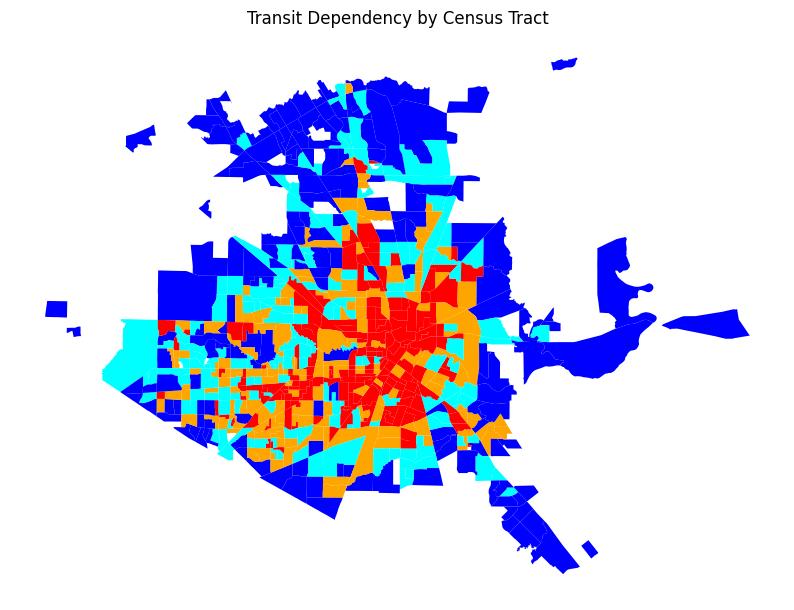

In [40]:
# Plot census tracts by transit supply quartile

# Ensure 'quartile' column exists and contains the expected values
print(gdf['quartile'].value_counts())

# Define a color map for the quartiles
quartile_colors = {
    'Low': 'blue',
    'Moderate-Low': 'cyan',
    'Moderate-High': 'orange',
    'High': 'red'
}

# Plot the GeoDataFrame with the specified colors for quartiles
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf.plot(column='quartile', 
         ax=ax, 
         legend=True,
         legend_kwds={'title': "Transit Supply Quartiles"},
         color=[quartile_colors[q] for q in gdf['quartile']])

# Add a title and axes labels
ax.set_title('Transit Supply by Census Tract')
ax.set_axis_off()

# Show the plot
plt.show()